In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
import xgboost as xgb


In [3]:
from sklearn.model_selection import train_test_split

# # Data inladen
df = pd.read_csv("final_df.csv")
print(df.head())
# df = groot_gemid_df

# Eerst de data opschudden om bias te voorkomen
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Zorg ervoor dat elke ervaring, geslacht en gewichtsklasse in elke set vertegenwoordigd zijn
train_data = pd.DataFrame()
val_data = pd.DataFrame()
test_data = pd.DataFrame()

for ervaring in df['ervaring'].unique():
    for geslacht in df['binary_geslacht'].unique():
        for gewichtsklasse in df['binary_gewichtsklasse'].unique():
            subset = df[(df['ervaring'] == ervaring) & (df['binary_geslacht'] == geslacht) & (df['binary_gewichtsklasse'] == gewichtsklasse)]
            if not subset.empty:
                temp_train, temp_temp = train_test_split(subset, test_size=0.3, random_state=42)
                temp_val, temp_test = train_test_split(temp_temp, test_size=0.3, random_state=42)
                train_data = pd.concat([train_data, temp_train])
                val_data = pd.concat([val_data, temp_val])
                test_data = pd.concat([test_data, temp_test])

# Reset indexen
train_data.reset_index(drop=True, inplace=True)
val_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

# Controleren op juiste verdeling
print(f"Trainingsdata: {len(train_data)} rijen")
print(f"Validatiedata: {len(val_data)} rijen")
print(f"Testdata: {len(test_data)} rijen")

# # Optioneel: data opslaan in aparte bestanden
# train_data.to_csv('train_data.csv', index=False)
# val_data.to_csv('val_data.csv', index=False)
# test_data.to_csv('test_data.csv', index=False)

print(df['2k tijd'].min())
print(df['2k tijd'].max())

   ervaring  500_split  2k tijd  binary_trainingtype  binary_geslacht  \
0         1      104.6    379.9                    0                0   
1         1      104.7    379.9                    0                0   
2         1      104.3    379.9                    0                0   
3         1      104.0    379.9                    0                0   
4         1      104.1    379.9                    0                0   

   binary_gewichtsklasse  
0                      1  
1                      1  
2                      1  
3                      1  
4                      1  
Trainingsdata: 3018 rijen
Validatiedata: 905 rijen
Testdata: 391 rijen
371.8
510.1


In [18]:
def rmse_scorer(y_true, y_pred):
    return -np.sqrt(mean_squared_error(y_true, y_pred))

scorer = make_scorer(rmse_scorer, greater_is_better=False)

def bin_targets(y, bins=5):
    return pd.qcut(y, q=bins, duplicates="drop").cat.codes

X_train = train_data.drop(columns=['2k tijd'])
y_train = train_data['2k tijd']

X_val = val_data.drop(columns=['2k tijd'])
y_val = val_data['2k tijd']

X_test = test_data.drop(columns=['2k tijd'])
y_test = test_data['2k tijd']

def feature_engineering(df):
    df['interaction_split_training'] = df['500_split'] * df['binary_trainingtype']
    df['interaction_split_geslacht'] = df['500_split'] * df['binary_geslacht']
    df['interaction_split_ervaring'] = df['500_split'] * df['ervaring']
    # df['interaction_split_gewicht'] = df['500_split'] * df['binary_gewichtsklasse']
    if '500_split' in df.columns:
        df['log_500_split'] = np.log1p(df['500_split'])  # Log-transform to reduce skewness
    return df

X_train = feature_engineering(X_train)
X_val = feature_engineering(X_val)
X_test = feature_engineering(X_test)

y_train_bins = bin_targets(y_train)

# StratifiedKFold for balanced splits
kf = KFold(n_splits=3, shuffle=True, random_state=42)

Cross-Validated RMSE: -8.105
mse_train = 46.49587068542317
mse_test = 50.47442745414251
mse_val = 65.10783808105204
rmse_test = 7.104535695887699
train_r2 = 0.9552547979961161
val_r2 = 0.9363529438722402
test_r2 = 0.9508485583109988
   Actual 2k tijd  Predicted 2k tijd (XGBoost)  Difference (XGBoost)
0           427.7                   420.060150              7.639850
1           420.5                   426.453308             -5.953308
2           418.6                   423.556427             -4.956427
3           427.7                   426.486664              1.213336
4           427.7                   427.714294             -0.014294
5           420.5                   424.749390             -4.249390
6           421.9                   419.231293              2.668707
7           449.0                   430.055420             18.944580
8           431.6                   430.737152              0.862848
9           431.6                   424.724548              6.875452


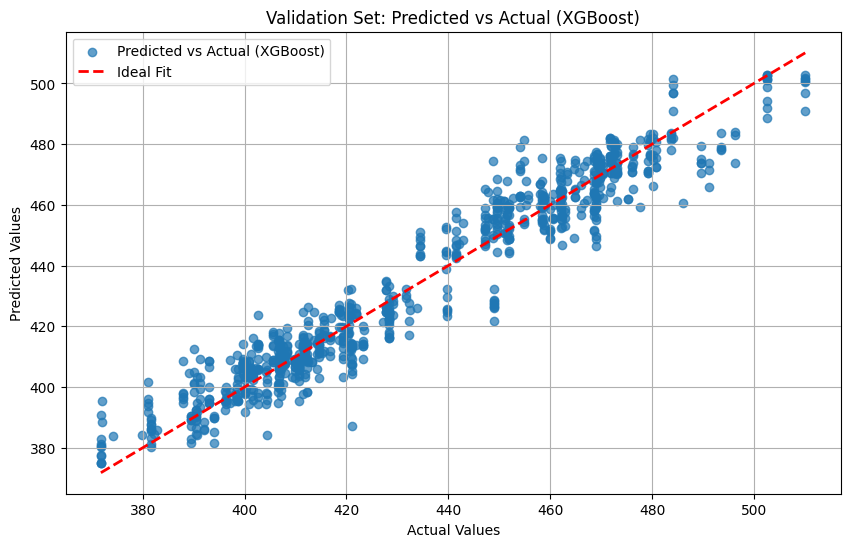

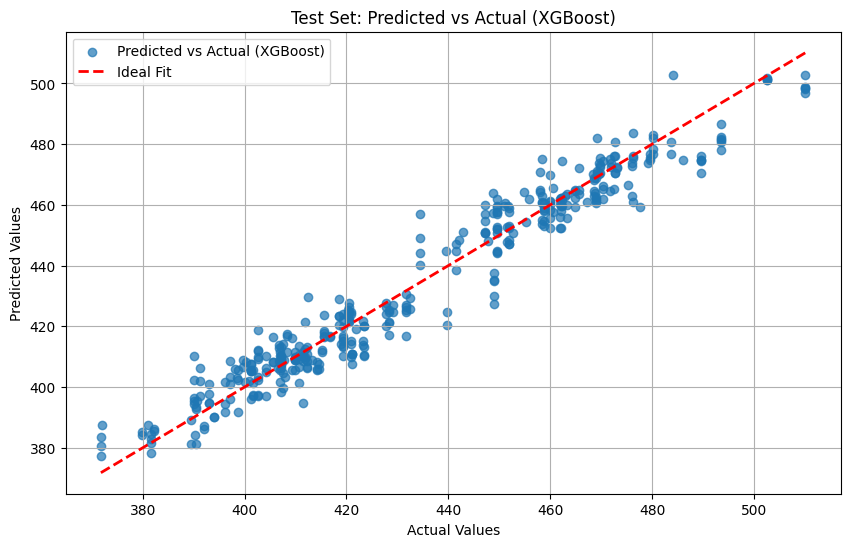

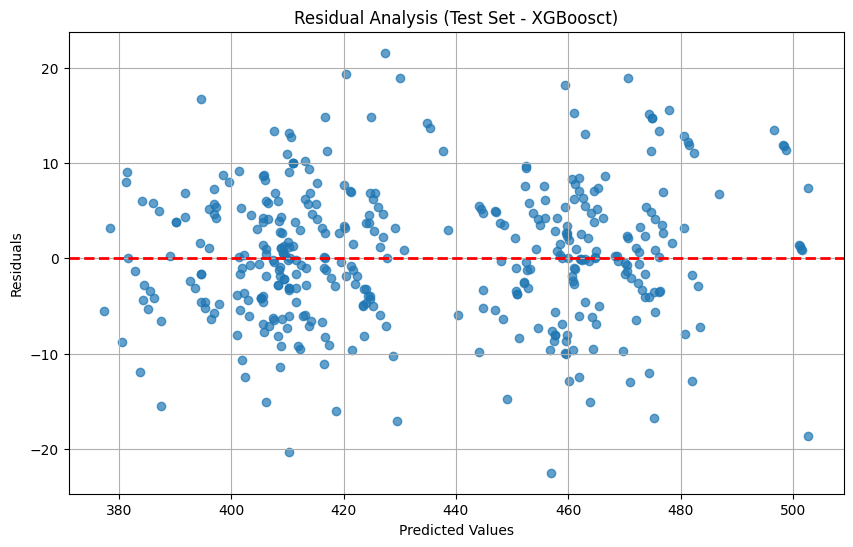

<Figure size 1000x600 with 0 Axes>

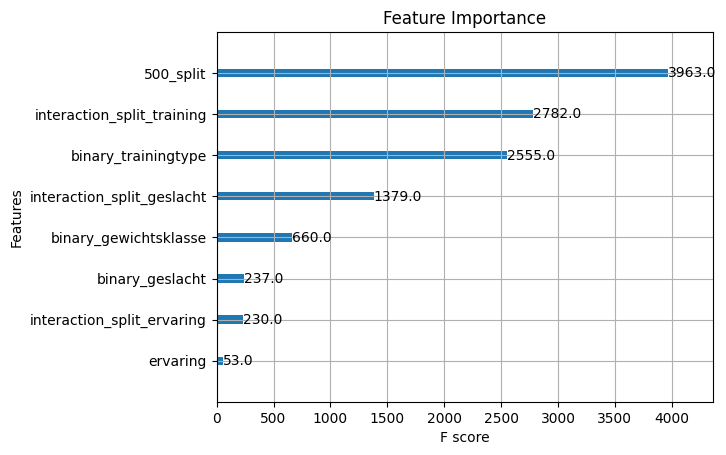

Test RMSE: 7.104535695887699


<Figure size 2000x1000 with 0 Axes>

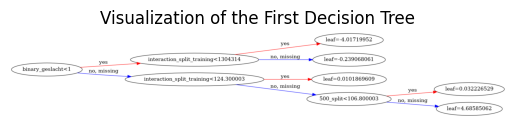

<Figure size 2000x1000 with 0 Axes>

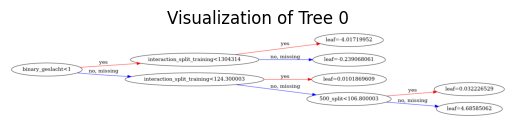

<Figure size 2000x1000 with 0 Axes>

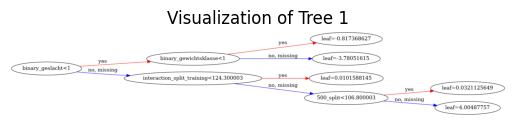

<Figure size 2000x1000 with 0 Axes>

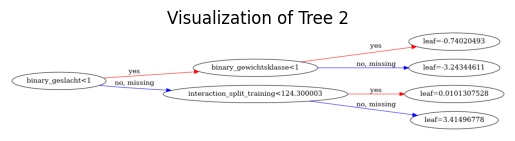

In [19]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42, reg_lambda=500, min_child_weight=7, colsample_bytree=1, learning_rate=0.2, max_depth=7, n_estimators=300)

cv_scores = cross_val_score(xgb_model, X_train, y_train, scoring=scorer, cv=kf)
print(f"Cross-Validated RMSE: {-np.mean(cv_scores):.3f}")
xgb_model.fit(X_train, y_train)

train_pred = xgb_model.predict(X_train)
test_pred = xgb_model.predict(X_test)
val_pred = xgb_model.predict(X_val)

mse_train = mean_squared_error(y_train, train_pred)
mse_test = mean_squared_error(y_test, test_pred)
mse_val = mean_squared_error(y_val, val_pred)
print(f"mse_train = {mse_train}")
print(f"mse_test = {mse_test}")
print(f"mse_val = {mse_val}")

rmse_test = np.sqrt(mse_test)
print(f"rmse_test = {rmse_test}")

# example_input = np.array([[1, 104.6, 0, 0, 1]])
# example_prediction = xgb_model.predict(example_input)
# print(f"Example prediction: {example_prediction}")

train_r2 = r2_score(y_train, train_pred)
val_r2 = r2_score(y_val, val_pred)
test_r2 = r2_score(y_test, test_pred)

print(f"train_r2 = {train_r2}")
print(f"val_r2 = {val_r2}")
print(f"test_r2 = {test_r2}")

results_xgb = pd.DataFrame({
    'Actual 2k tijd': y_test,
    'Predicted 2k tijd (XGBoost)': test_pred,
    'Difference (XGBoost)': y_test - test_pred
})
print(results_xgb.head(10))

plt.figure(figsize=(10, 6))
plt.scatter(y_val, val_pred, alpha=0.7, label='Predicted vs Actual (XGBoost)')
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color='red', linestyle='--', linewidth=2, label='Ideal Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Validation Set: Predicted vs Actual (XGBoost)')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(y_test, test_pred, alpha=0.7, label='Predicted vs Actual (XGBoost)')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', linewidth=2, label='Ideal Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Test Set: Predicted vs Actual (XGBoost)')
plt.legend()
plt.grid(True)
plt.show()

residuals_xgb = y_test - test_pred
plt.figure(figsize=(10, 6))
plt.scatter(test_pred, residuals_xgb, alpha=0.7)
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Analysis (Test Set - XGBoosct)')
plt.grid(True)
plt.show()

#feature analysis
plt.figure(figsize=(10, 6))
xgb.plot_importance(xgb_model, importance_type='weight', max_num_features=10)
plt.title("Feature Importance")
plt.show()

test_pred = xgb_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
print("Test RMSE:", test_rmse)

from xgboost import plot_tree
import matplotlib.pyplot as plt

# Visualize the first tree in the XGBoost model
plt.figure(figsize=(20, 10))
plot_tree(xgb_model, num_trees=0, rankdir='LR')  # num_trees=0 visualizes the first tree
plt.title("Visualization of the First Decision Tree")
plt.show()

# To visualize more trees, loop through and plot them
num_trees_to_plot = 3  # Adjust this to control the number of trees to visualize
for i in range(num_trees_to_plot):
    plt.figure(figsize=(20, 10))
    plot_tree(xgb_model, num_trees=i, rankdir='LR')
    plt.title(f"Visualization of Tree {i}")
    plt.show()


In [14]:
param_grid = {'reg_lambda': [0.1, 1, 10, 100, 150, 500], 
              'min_child_weight': [1, 3, 5, 7, 9, 12], 
              'colsample_bytree': [0.6, 0.8, 1.0],
              'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.5, 0.8, 1, 1.2, 1.5],
              'max_depth': [3, 5, 7],
              'n_estimators': [100, 200, 300, 400, 500]}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

grid_search.fit(X_train, y_train)

best_lambda = grid_search.best_params_['reg_lambda']
best_min_child_weight = grid_search.best_params_['min_child_weight']
best_colsample = grid_search.best_params_['colsample_bytree']
best_learningrate = grid_search.best_params_['learning_rate']
best_maxdepth = grid_search.best_params_['max_depth']
best_nestimators = grid_search.best_params_['n_estimators']
print('Best lambda (reg_lambda):', best_lambda)
print('Best child weight:', best_min_child_weight)
print('Best colsample:', best_colsample)
print('Best learning rate:', best_learningrate)
print('Best maxdepth:', best_maxdepth)
print('Best estimators:', best_nestimators)


Best lambda (reg_lambda): 500
Best child weight: 9
Best colsample: 1.0
Best learning rate: 1.5
Best maxdepth: 5
"Best estimators: 200
